In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import viz

from matplotlib.ticker import FuncFormatter
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import linregress

colors = viz.plotting_style()
lin_colors = list(colors.values())
greys = sns.color_palette('Greys', 6)

plt.style.use('style.mpl')

# Code generating Figure 1 
Figure 1 describes "stylized facts" about microbial metabolism and growth that motivate the integration of redox and resource allocation models. 

Also generates any supplementary figures that are plausibly attached to Figure 1.

In [2]:
# Load E. coli growth rates from Schmidt et al. 2016
coli_data = pd.read_csv('../data/proteomes/Coli/Chure_proteome_NOSC.csv')
mask = np.logical_and(
    coli_data.dataset.str.contains('schmidt'),
    coli_data.growth_mode != 'chemostat') 
stress_conds = 'pH6,osmotic_stress_glucose,42C'.split(',')
mask = np.logical_and(mask, ~coli_data.condition.isin(stress_conds))
coli_csource_df = coli_data[mask].sort_values('growth_rate_hr')
coli_csource_df.condition.replace({'glycerol_pAA': 'glycerol + AA', 'lb_miller': 'rich (LB)'}, inplace=True)

In [3]:
# Chemostat example. Maximum growth rate exists.
kayser_chemostat_df = pd.read_csv('../data/chemostat_data/kayser_chemostat_growth_unit_conv.csv')

# Metabolic modes of E. coli
coli_modes_df = pd.read_excel('../data/physiology/coli_metabolic_modes.xlsx', index_col=0)

# Load biomass macromolecular composition from Bremer & Dennis 2008
biomass_percent_df = pd.read_csv('../data/physiology/BremerDennis2008_BiomassComposition_pct.csv', index_col=0)

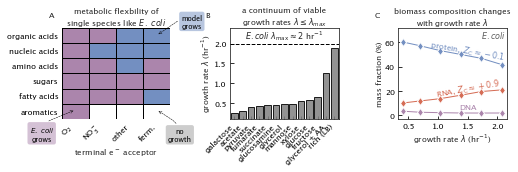

In [4]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(7.24, 2.5))
        
# Panel on range of metabolic modes. 
plt.sca(axs[0])
coli_modes_num = coli_modes_df.replace(
    {'experiment': 3, 'engineered': 2, 'model': 1, np.NAN: 0})
cmap = ['w'] + [colors[x] for x in 'blue,green,purple'.split(',')]
sns.heatmap(coli_modes_num, cmap=cmap, cbar=False, linewidths=0.5, linecolor='black')
plt.ylabel('')
plt.xlabel('')
tick_labels = {
    'CO2': 'CO$_2$',
    'O2': 'O$_2$', 
    'NO3': 'NO$_3^{-}$',
    'DMSO/TMAO': 'other',
    'fermentation': 'ferm.'}
my_ticks = [tick_labels[x] for x in coli_modes_num.columns]
plt.xticks(np.arange(len(my_ticks))+0.5, my_ticks, rotation=45, ha='right')
plt.tick_params(axis=u'both', which=u'both', length=0)
plt.xlabel('terminal e$^-$ acceptor')

# annotate the growth/non-growth with plt.annotate using same coordinates and positions as figtext
arrowprops = dict(
    arrowstyle="->",
    connectionstyle="arc,angleA=90,armA=10,rad=10",
    linestyle='--',
    facecolor='black', edgecolor='black', lw=0.5)
bbox = dict(boxstyle="round", fc=colors['purple'], ec="w", lw=0, alpha=0.5)
plt.annotate('$E.$ $coli$\ngrows', xy=(0.5, 5.4), xytext=(0.08, 0.17), textcoords='figure fraction',
             fontsize=7, ha='center', color='k', annotation_clip=True, arrowprops=arrowprops, bbox=bbox)
bbox = dict(boxstyle="round", fc=colors['blue'], ec="w", lw=0, alpha=0.5)
plt.annotate('model\ngrows', xy=(3.5, 0.5), xytext=(0.368, 0.8), textcoords='figure fraction',
             fontsize=7, ha='center', color='k', annotation_clip=True, arrowprops=arrowprops, bbox=bbox)
bbox = dict(boxstyle="round", fc=greys[-2], ec="w", lw=0, alpha=0.3)
plt.annotate('no\ngrowth', xy=(3.5, 5.4), xytext=(0.345, 0.17), textcoords='figure fraction',
             fontsize=7, ha='center', color='k', annotation_clip=True, arrowprops=arrowprops, bbox=bbox)

# Panel on maximum growth rate -- E. coli growth rates by C-source from Schmidt 2016.
plt.sca(axs[1])
sns.barplot(data=coli_csource_df, y='growth_rate_hr', x='condition', color='grey',
            alpha=0.85, edgecolor='k', lw=1)
plt.axhline(2.0, color='k', ls='--', lw=1)
plt.xticks(rotation=45, ha='right')# , fontsize=6)
plt.ylim(0.1, 2.4)
plt.text(6, 2.03, '$E. coli$ $\lambda_{\mathrm{max}} \\approx 2$ hr$^{-1}$', va='bottom', ha='center', fontsize=8)

plt.ylabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.xlabel('')

plt.sca(axs[2])
labels = 'protein,RNA,DNA'.split(',')
keys = ['{0}_percent'.format(l) for l in labels]

# Plot the fractional composition of biomass.
pal = [colors[cid] for cid in "blue,red,purple".split(",")]
for l,k,c in zip(labels, keys, pal):  
    ys = biomass_percent_df[k]
    plt.plot(biomass_percent_df.growth_rate_hr, ys, marker='d', label=l,
             markersize=6, markeredgecolor='w', lw=1, color=c)

labels = ["protein, $Z_{\mathrm{C}} \\approx -0.1$", 
          "RNA, $Z_{\mathrm{C}} \\approx +0.9$",
          "DNA"]
lcolors = ['blue', 'red', 'purple']
locs = [(1.5, 54, -10), (1.5, 23, 10), (1.5, 7, 0)]
for label, c, loc in zip(labels, lcolors, locs):
    x,y,rotation = loc
    plt.text(x, y, label, ha='center', va='center', color=colors[c],
             transform=plt.gca().transData, rotation=rotation, fontsize=8)

plt.xlabel('growth rate $\lambda$ (hr$^{-1}$)')
plt.ylabel('mass fraction (%)')
plt.tick_params(axis='both')
plt.legend(loc=1).set_visible(False)
plt.ylim(-3, 72)
plt.text(0.99, 0.98, '$E. coli$', transform=plt.gca().transAxes,
         ha='right', va='top', color=greys[-2], fontsize=8)


titles = ["metabolic flexbility of\nsingle species like $E.$ $coli$",
          "a continuum of viable\ngrowth rates $\lambda \leq \lambda_{max}$",
          "biomass composition changes\nwith growth rate $\lambda$"]
for ax, title in zip(axs, titles):
    ax.set_title(title)

label_pos = [(0.1, 0.88), (0.40, 0.88), (0.725, 0.88)]
for (x,y), label in zip(label_pos, 'ABC'):
    plt.figtext(x, y, label, fontsize=8, weight='bold')

plt.tight_layout()
plt.savefig('../output/Fig1.pdf', facecolor='white', dpi=300)
plt.show()

In [5]:
# Make a binary version of the growth matrix for plotting
growth_mat_df = pd.read_csv('../output/iML1515_growth_rate_matrix.csv', index_col=[0,1])
binary_growth_mat_df = pd.read_csv('../output/iML1515_binary_growth_matrix.csv', index_col=[0,1])

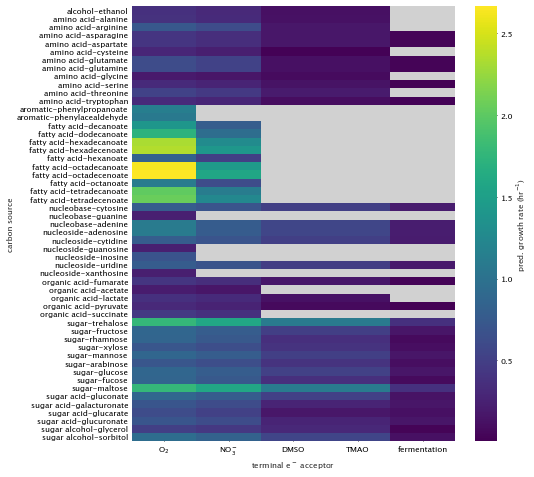

In [6]:
cols = 'O2,NO3,DMSO,TMAO,fermentation'.split(',')
cmap = sns.color_palette('cividis', as_cmap=True)
cmap.set_bad('white')

plt.figure(figsize=(7.24, 8))
nice_labels = dict(O2='O$_2$', NO3='NO$_3^{-}$', DMSO='DMSO', TMAO='TMAO', fermentation='fermentation')
xticklabels = [nice_labels.get(x, x) for x in cols]
growth_mat_df[growth_mat_df == 0] = np.nan
my_cmap = sns.color_palette('viridis', as_cmap=True)
my_cmap.set_bad(greys[1])
sns.heatmap(growth_mat_df[cols], cbar=True, fmt='', 
            cbar_kws=dict(label='pred. growth rate (hr$^{-1}$)'),
            xticklabels=xticklabels, cmap=my_cmap)
plt.xlabel('terminal e$^-$ acceptor')
plt.ylabel('carbon source')

plt.savefig('../output/FigSX_iML1515_growth_matrix.png', dpi=300, bbox_inches='tight', facecolor='white')